##Test mesh distortion bug
 
 * Aim is to be able start with a regular mesh, distort the mesh, then visualize a field on that distorted mesh 

In [1]:
# Stagnant lid convection model

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pylab as pyplot
import numpy as np

In [2]:
dim = 2
meshX = 100
meshY = 100
maxX = 1 
maxY = 1


elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0',
                                      elementRes=(meshX,meshY), 
                                      minCoord=(0.,0.), maxCoord=(maxX,maxY )  )


linearMesh   = elementMesh
constantMesh = elementMesh.subMesh


In [3]:
A= 0.02
def sin_pert(x):
    return A*math.sin((2*math.pi*x)/0.1)

In [4]:
with elementMesh.deform_mesh():
    for index, coord in enumerate(elementMesh.data):
        y0 = coord[1]
        pert = sin_pert(coord[0])
        elementMesh.data[index][1] = y0 + ((y0/maxY)*pert)

In [5]:
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

temperatureField.data[:] = 0.

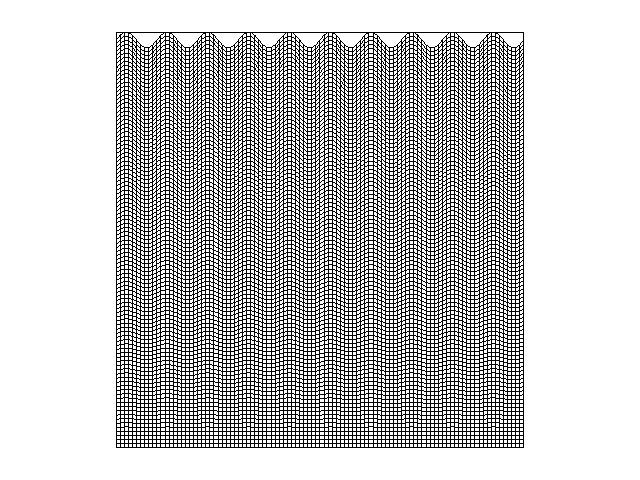

In [6]:
meshfig = plt.Figure()
meshfig.Mesh(elementMesh, colourBar=False)
#meshfig.Surface(temperatureField,linearMesh)
meshfig.show()

In [7]:
for index, coord in enumerate(elementMesh.data):
    pert = sin_pert(coord[0])
    maxY = 1 + pert
    temperatureField.data[index] = (maxY - coord[1])

In [8]:
meshfig = plt.Figure()
#meshfig.Mesh(elementMesh, colourBar=False)
meshfig.Surface(temperatureField,linearMesh)
meshfig.show()

RuntimeError: FeVariable interpolation at location (0, 1.00873) does not appear to be valid.
Location is probably outside local domain.

##Now test if zero-flux temp BCs apply by default if Dirichlet conditions aren't set

###first: steady state heat

In [9]:
mesh = uw.mesh.FeMesh_Cartesian('Q1', (128,128), (-2,-1.), (2,1.))
temperatureField = uw.fevariable.FeVariable(mesh,1)

In [10]:
# declare which nodes are to be considered as boundary nodes
topNodes = mesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = mesh.specialSets["MinJ_VertexSet"]
conditions = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)

In [11]:
# init tempfield to zero everywhere
temperatureField.data[:] = 0.
# setup required values on boundary nodes
temperatureField.data[topNodes.data]    = 0.
#temperatureField.data[bottomNodes.data] = 1.

In [12]:
# setup system
steadyStateThermal = uw.systems.SteadyStateHeat(temperatureField,1.,conditions=[conditions,])

In [13]:
steadyStateThermal.solve()

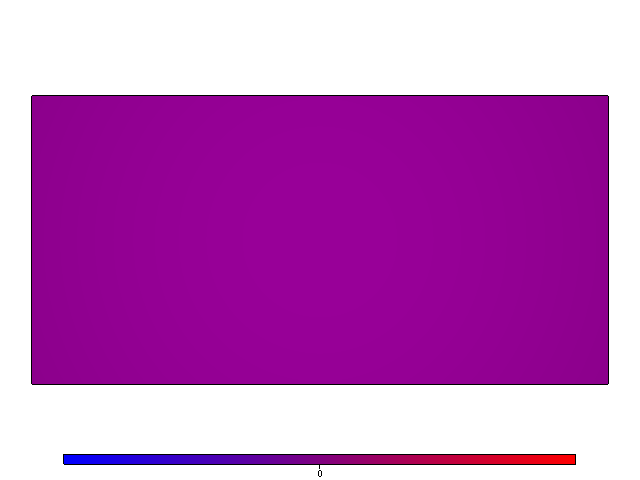

In [14]:
# now lets look
fig = plt.Figure()
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

* So it seems like a zero flux condition does apply (but could something else be going on here?) 

###second: advection diffusion 

In [2]:
dim = 2
# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q2/dPc1', 
                                         elementRes=(128,128), 
                                           minCoord=(-2.,-1.), 
                                           maxCoord=(2.,1.)  )

linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [3]:
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [4]:

# create & zero fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
temperatureField.data[:] = 0.5

In [5]:
# declare which nodes are to be considered as boundary nodes
topNodes = linearMesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = linearMesh.specialSets["MinJ_VertexSet"]
conditions = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)

In [6]:
# setup required values on boundary nodes
temperatureField.data[topNodes.data]    = 0.
temperatureField.data[bottomNodes.data] = 1.

In [7]:
velocityField.data[:] = [0,0]
kappa = 1.
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=kappa, conditions=[conditions,] )

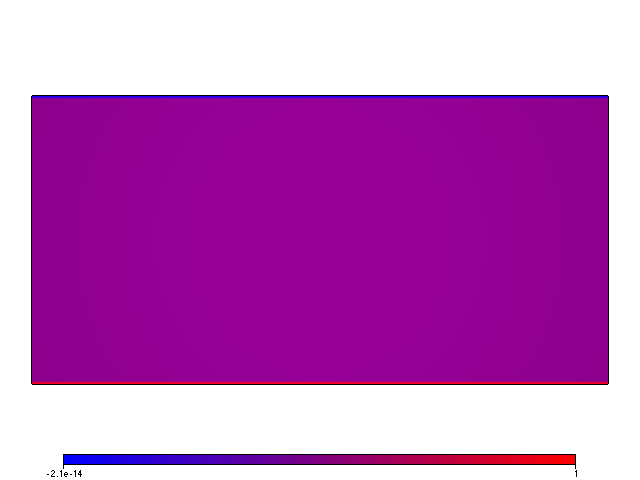

In [8]:
fig2 = plt.Figure()
fig2.Surface(temperatureField,linearMesh, colours=['blue','red'])
fig2.show()

In [9]:
step = 0
while step < 2:
    dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    step += 1

In [ ]:
fig3 = plt.Figure()
fig3.Surface(temperatureField,linearMesh, colours=['blue','red'])
fig3.show()